# Heterogeneous Graphs

## A Simple Citation Network

Consider the following citation network with two node types (author, paper) and two edge types (cites, writes):

![alt text](assets/w9_g1.png "")

1. Formally define this graph $G=(V,E,\tau,\phi)$.

1. Given the edges existing in this graph, list all relation types. Hint: A relation is defined as (node_start, edge, node_end).

1. Assume that both edge types ("writes" and "cites") can connect any types of nodes. In that case, how many different relation types can be defined for this graph?

1. What is the generic formula for the case in (3), in terms of numbers of node and edge types?

1. Why does Relational GCN (RGCN) has parameters for different relation types instead of just edge types? What behavior could not be captured if only edge type were used?

## When do we really need heterogeneity?

Consider the small academic network given in Exercise 1.

1. Construct a homogeneous version by turning node and edge types into one-hot features.

1. Describe one concrete situation where this homogeneous encoding is insufficient.

1. In the one-hot feature scenario, give an example where two node types have identical feature dimensions but still require a heterogeneous representation. Why isn't dimensionality the real issue?

## Relational GCN (RGCN)

R-GCN ([paper link](https://arxiv.org/pdf/1703.06103)) has the following propagation model:

$$
    h_{v}^{(l+1)} = \sigma \left( \sum_{r \in R} \sum_{u \in N_{v}^{r}} \frac{1}{c_{v,r}} W_{r}^{(l)}h_{u}^{l} + W_{0}^{(l)}h_{v}^{l} \right)
$$

1. What would happen if $1/c_{v,r}$ were omitted in a graph where some relation types are very dense and others very sparse?

1. Let's assume we are working with a graph that has $|\mathcal{R}|$ relation types, and we train an $L$-layer R-GCN with $d$ hidden dimensions in each layer. What would be the number of parameters to learn?

1. Assume that we use $B$ blocks in each $W$, what would be the total number of parameters?

## Programming: GCN and R-GCN

Let's experiment with the toy citation network from Exercise 1. We will consider the following scenarios:

- Regular GCN, ignoring node and edge types
- Regular GCN, types as one-hot features
- RGCN

Since this network is too simple, we won't actually train these models, but inspect the embeddings we get with 1-hop forward pass.

The following code snippet constructs the graph in `PyG` and runs each scenario. Then, embeddings are printed and plotted on a 2d plot.

GCN output embeddings:
tensor([[-0.3313,  1.2991],
        [-0.3313,  1.2991],
        [-0.3999,  1.5682],
        [-0.4370,  1.7134],
        [-0.4122,  1.6161]])

GCN + node type one-hots output embeddings:
tensor([[1.1572, 0.6766],
        [1.1572, 0.6766],
        [1.6990, 0.4753],
        [1.9744, 0.3859],
        [1.8424, 0.3864]])

RGCN output embeddings:
tensor([[-0.6516, -0.1658],
        [-0.6516, -0.1658],
        [ 0.4386,  0.0432],
        [-0.2216,  0.4037],
        [-0.2216,  0.4037]])


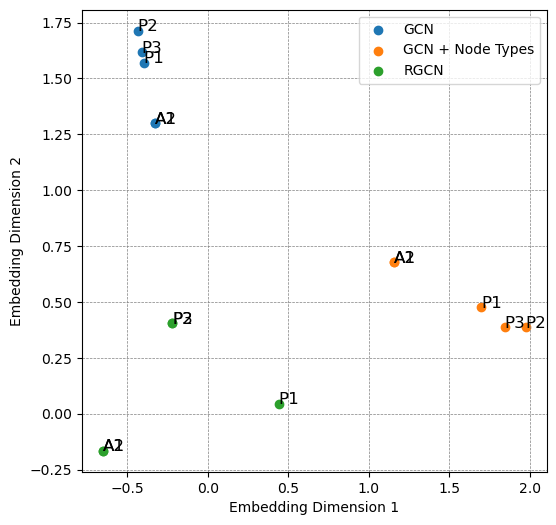

In [ ]:
import torch
from torch_geometric.nn import GCNConv, RGCNConv
import matplotlib.pyplot as plt

# torch seed for reproducibility
torch.manual_seed(42)

# Nodes: 0: A1, 1: A2, 2: P1, 3: P2, 4: P3
num_nodes = 5

# Edges: A1->P1, A1->P2, A2->P3, P1->P2, P2->P3
edge_index = torch.tensor([
    [0, 0, 1, 2, 3],  # sources
    [2, 3, 4, 3, 4],  # targets
])

# Edge types: 0 for A->P, 1 for P->P
edge_type=torch.tensor([0, 0, 0, 1, 1])

# Initial node features: all ones
x = torch.ones((num_nodes, 1))

class GCN(torch.nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.conv = GCNConv(d_in, d_out)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        return x

class RGCN(torch.nn.Module):
    def __init__(self, d_in, d_out, num_relations):
        super().__init__()
        self.conv = RGCNConv(d_in, d_out, num_relations)

    def forward(self, x, edge_index, edge_type):
        x = self.conv(x, edge_index, edge_type)
        return x

# 1. Plain GCN 
model_gcn = GCN(1, 2)  
out_gcn = model_gcn(x, edge_index)
print("GCN output embeddings:")
emb_gcn = out_gcn.detach()
print(emb_gcn)

# 2. GCN + node type one-hots  
x_type = torch.tensor([[1,0],[1,0],[0,1],[0,1],[0,1]])  # A=[1,0], P=[0,1]
model_type = GCN(3, 2)
out_type = model_type(torch.cat([x, x_type], dim=1), edge_index)
print("\nGCN + node type one-hots output embeddings:")
emb_type = out_type.detach()
print(emb_type)

# 3. RGCN with relation types
model_rgcn = RGCN(1, 2, num_relations=2)
out_rgcn = model_rgcn(x, edge_index, edge_type=edge_type)
print("\nRGCN output embeddings:")
emb_rgcn = out_rgcn.detach()
print(emb_rgcn)

# plot embeddings
def plot_embeddings(ax, emb):
    ax.scatter(emb[:, 0], emb[:, 1])
    node_labels = ['A1', 'A2', 'P1', 'P2', 'P3']
    for i in range(emb.size(0)):
        ax.text(emb[i, 0], emb[i, 1], node_labels[i], fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_embeddings(ax, emb_gcn)
plot_embeddings(ax, emb_type)
plot_embeddings(ax, emb_rgcn)
ax.set_xlabel('Embedding Dimension 1')
ax.set_ylabel('Embedding Dimension 2')
ax.grid(linewidth=0.5, linestyle='--', color='gray')
ax.legend(['GCN', 'GCN + Node Types', 'RGCN'])
plt.show()

What's going on?! We have interesting results:

1. Why `A1` and `A2` have identical embeddings in all scenarios, although their neighborhoods are different?

1. Why `P2` and `P3` are different in scenarios (1) and (2), but collapse in RGCN? 